In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torchmetrics
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image
from transformers import AutoImageProcessor
from torchvision.transforms import v2

torch.manual_seed = 42

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-2].split("_")[0]
            tissue_num = img.split("_")[-2]
            if slide_num == "SQ1631":
                if tissue_num == "s1":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "s4":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(2)
            elif slide_num == "SQ1634":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1635":
                if tissue_num == "s3" or tissue_num == "s4":
                    self.labels.append(2)
                elif tissue_num == "s1":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "s4":
                    self.labels.append(1)
                else:
                    self.labels.append(2)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB') 
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [3]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/raw_img/'
dataset = CustomImageDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

tensor([1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0,
        2, 2, 2, 1, 2, 0, 1, 2])


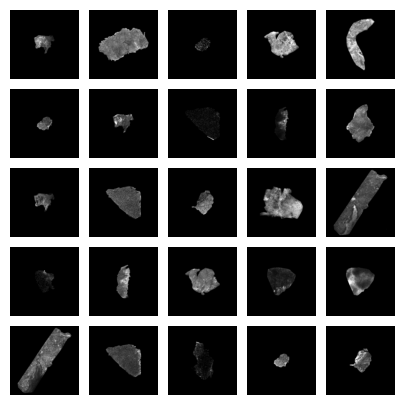

In [4]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
print(labels)
num_samples = 25
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [5]:
from transformers import ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 3 # number of classes in the output

/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
def split_dataset(dataset):
    """
    Splits a PyTorch dataset into two equal halves sequentially.
    Args:
        dataset: PyTorch Dataset object
    Returns:
        first_half, second_half: Two SubsetDataset objects
    """
    split_idx = len(dataset) >> 1  # Equivalent to len(dataset) // 2
    
    first_indices = range(split_idx)
    second_indices = range(split_idx, len(dataset))
    
    # Use Subset to avoid data copying - memory efficient
    from torch.utils.data import Subset
    first_half = Subset(dataset, first_indices)
    second_half = Subset(dataset, second_indices)
    
    return first_half, second_half

train_seq, test_seq = split_dataset(dataset)

In [7]:
#train_size = int(0.5 * len(dataset))  # 70% for training
#test_size = len(dataset) - train_size  # Remaining 30% for testing
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_seq, batch_size=32, shuffle=True)
test_loader = DataLoader(test_seq, batch_size=32, shuffle=False)

In [8]:
from tqdm.notebook import tqdm
import torch

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


In [9]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

In [10]:
num_epochs = 5
device="cpu"
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)

Epoch 1/5


  0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.2327, Train Accuracy: 0.9572


Evaluating:   0%|          | 0/344 [00:00<?, ?it/s]

Test Loss: 2.8476, Test Accuracy: 0.4129
Epoch 2/5


  0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.0051, Train Accuracy: 0.9983


Evaluating:   0%|          | 0/344 [00:00<?, ?it/s]

Test Loss: 2.8370, Test Accuracy: 0.3826
Epoch 3/5


  0%|          | 0/344 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
cutmix_transform = v2.CutMix(
    num_classes=3,  # Replace with your number of classes
    alpha=0.5  # Controls the Beta distribution for mixing ratio
)

# Create complete transform pipeline
transform_train = v2.Compose([
    # Add any other transforms you need before CutMix
    v2.ToImage(),  # Convert to torch tensor image
    v2.ToDtype(torch.float32, scale=True),  # Convert to float32 and scale to [0,1]
    cutmix_transform
])
cutmix_train_dataset = train_dataset
# Apply to your training dataset
cutmix_train_dataset.transform = transform_train

# create training dataloader as usual
cutmix_train_loader = DataLoader(cutmix_train_dataset, batch_size=32, shuffle=True)

NameError: name 'train_dataset' is not defined

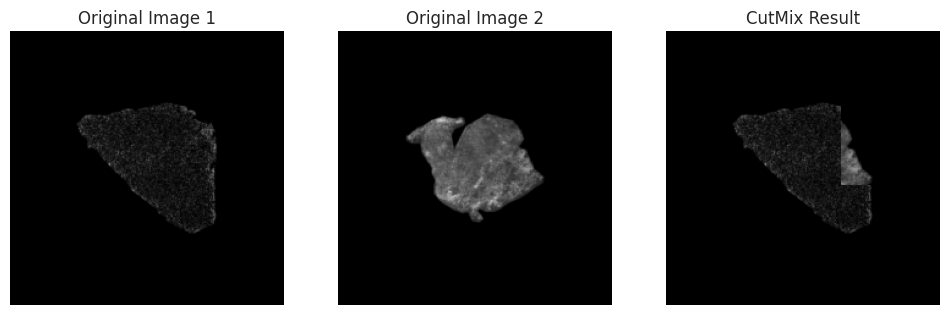

Mixed labels: tensor([0.1905, 0.8095, 0.0000])


In [18]:
transform_pipeline = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Get two sample images
img1 = transform_pipeline(cutmix_train_dataset[0][0])  # First image
img2 = transform_pipeline(cutmix_train_dataset[1][0])  # Second image

# Create a batch of these two images
batch = torch.stack([img1, img2])
labels = torch.tensor([cutmix_train_dataset[0][1], cutmix_train_dataset[1][1]])  # Their labels

# Apply CutMix
mixed_batch, mixed_labels = cutmix_transform(batch, labels)

# Display original and mixed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title('Original Image 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2.permute(1, 2, 0))
plt.title('Original Image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mixed_batch[0].permute(1, 2, 0))  # Show first mixed image
plt.title('CutMix Result')
plt.axis('off')

plt.show()

# Print mixing information
print(f"Mixed labels: {mixed_labels[0]}")  # Show label distribution for first image

In [94]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, num_classes, cutmix_prob=0.5, alpha=1.0):
        self.dataset = original_dataset
        self.cutmix = v2.CutMix(num_classes=num_classes, alpha=alpha)
        self.cutmix_prob = cutmix_prob
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Decide whether to use CutMix based on probability
        use_cutmix = torch.rand(1).item() < self.cutmix_prob
        
        if not use_cutmix:
            img, label = self.dataset[index]
            img = self.transform(img)
            # Create one-hot distribution for original image (1.0 for true class, 0 elsewhere)
            label_dist = torch.zeros(self.num_classes, dtype=torch.float32)
            label_dist[label] = 1.0
            return img, label_dist
        
        # Apply CutMix
        img1, label1 = self.dataset[index]
        idx2 = torch.randint(len(self.dataset), (1,)).item()
        img2, label2 = self.dataset[idx2]
        
        img1, img2 = self.transform(img1), self.transform(img2)
        batch = torch.stack([img1, img2])
        labels = torch.tensor([label1, label2], dtype=torch.long)
        
        mixed_batch, mixed_labels = self.cutmix(batch, labels)
        return mixed_batch[0], mixed_labels[0]


In [96]:
# divide the original dataset into training set and test set, then augment the training set only
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

augmented_dataset = AugmentedDataset(dataset, num_classes=3)
train_loader = torch.utils.data.DataLoader(
    augmented_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

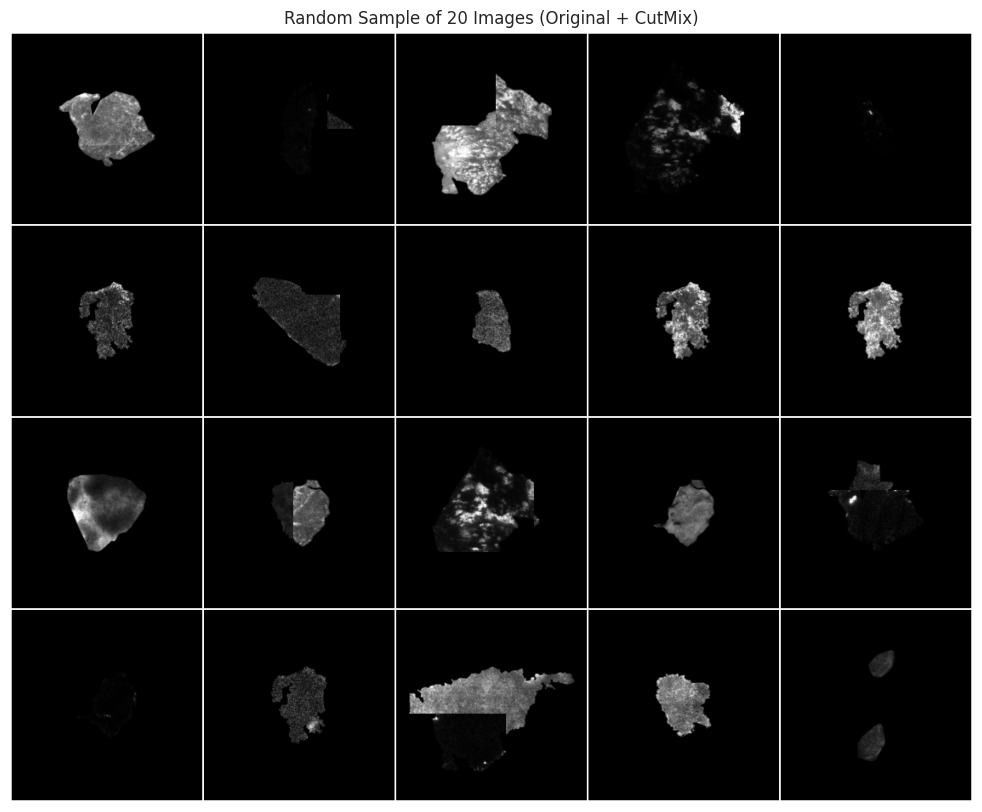

Image 1: tensor([1., 0., 0.])
Image 2: tensor([0., 0., 1.])
Image 3: tensor([0., 1., 0.])
Image 4: tensor([0., 1., 0.])
Image 5: tensor([0., 1., 0.])
Image 6: tensor([1., 0., 0.])
Image 7: tensor([0., 1., 0.])
Image 8: tensor([0., 1., 0.])
Image 9: tensor([1., 0., 0.])
Image 10: tensor([1., 0., 0.])
Image 11: tensor([0., 1., 0.])
Image 12: tensor([0., 0., 1.])
Image 13: tensor([1., 0., 0.])
Image 14: tensor([0., 0., 1.])
Image 15: tensor([0.0000, 0.6103, 0.3897])
Image 16: tensor([0., 0., 1.])
Image 17: tensor([1., 0., 0.])
Image 18: tensor([0., 0., 1.])
Image 19: tensor([0., 0., 1.])
Image 20: tensor([0., 0., 1.])


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Get 20 random indices
random_indices = np.random.randint(0, len(augmented_dataset), 20)

# Create figure
plt.figure(figsize=(20, 10))

# Get and display images
images = []
for idx in random_indices:
    img, label = augmented_dataset[idx]
    if isinstance(label, torch.Tensor) and len(label.shape) > 0:
        # For CutMix images, show the mix ratio in title
        label_str = f"Mix: {label.numpy().round(2)}"
    else:
        # For original images, show the class label
        label_str = f"Class: {label}"
        
    images.append(img)
    
# Create grid of images
grid = make_grid(images, nrow=5, normalize=True, pad_value=1.0)

# Display grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Random Sample of 20 Images (Original + CutMix)')
plt.show()

# Print labels
for i, idx in enumerate(random_indices):
    _, label = augmented_dataset[idx]
    print(f"Image {i+1}: {label}")

In [101]:
num_epochs = 5
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SoftCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        log_softmax = F.log_softmax(input, dim=1)
        return torch.mean(torch.sum(-target * log_softmax, dim=1))

# initialize optimizer, scheduler, and criterion
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
criterion = SoftCrossEntropyLoss()

num_classes = 3
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
model.classifier = torch.nn.Linear(model.config.hidden_sizes[-1], num_classes)

model = model.to(device)


best_acc = 0.0
best_model = None

print(f"Training on {device}")
print("=" * 50)

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, target_distributions in train_loader:
        inputs = inputs.to(device)
        target_distributions = target_distributions.to(device)

        outputs = model(inputs)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        loss = criterion(logits, target_distributions)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = logits.max(1)
        total += target_distributions.size(0)
        true_classes = target_distributions.max(1)[1]
        correct += predicted.eq(true_classes).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            loss = criterion(logits, targets)
            
            test_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    scheduler.step()
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model.state_dict().copy()
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.2f}s)")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    print("-" * 50)

torch.save(best_model, 'best_model.pth')
print(f"Training completed. Best test accuracy: {best_acc:.2f}%")

Training on cuda


RuntimeError: The size of tensor a (32) must match the size of tensor b (3) at non-singleton dimension 1